### Mean reversion strategy using the absolute price oscillator trading signal

1. We will fetch data the same way we have done in the past. Let's fetch 4 years of `GOOG` data. This code will use the `DataReader` function from the `pandas_datareader` package. This function will fetch the `GOOG` prices from Yahoo Finance between `2014-01-2014` and `2018-01-01`. If the `.pkl` file used to store the data on the disk is not present, the `GOOG_data.pkl` file will be created. By doing that, we ensure that we will use the file to fetch the `GOOG` data for future use:

In [1]:
import pandas as pd
from pandas_datareader import data

In [2]:
import yfinance as yf
yf.pdr_override()

In [3]:
# Fetch daily data for 4 years
SYMBOL='GOOG'
start_date = '2014-01-01'
end_date = '2018-01-01'
SRC_DATA_FILENAME=SYMBOL + '_data.pkl'

In [4]:
try:
    df = pd.read_pickle(SRC_DATA_FILENAME)
except FileNotFoundError:
    # df = data.DataReader(SYMBOL, 'yahoo', start_date, end_date)
    df = data.get_data_yahoo(SYMBOL, start=start_date, end=end_date)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,555.647278,556.788025,552.060730,554.481689,554.481689,3656400
2014-01-03,555.418152,556.379578,550.401978,550.436829,550.436829,3345800
2014-01-06,554.426880,557.340942,551.154114,556.573853,556.573853,3551800
2014-01-07,560.399475,567.717041,558.486633,567.303589,567.303589,5124300
2014-01-08,570.860291,571.517822,564.528992,568.484192,568.484192,4501700
...,...,...,...,...,...,...
2017-12-26,1058.069946,1060.119995,1050.199951,1056.739990,1056.739990,760600
2017-12-27,1057.390015,1058.369995,1048.050049,1049.369995,1049.369995,1271900
2017-12-28,1051.599976,1054.750000,1044.770020,1048.140015,1048.140015,837100


2. Now we will define some constants and variables we will need to perform Fast and Slow EMA calculations and APO trading signal:

In [5]:
# Variables/constants for EMA Calculation:
NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

3. We will also need variables that define/control strategy trading behavior and position and PnL management:

In [6]:
# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions,
                # +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl
            # i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy
                        # Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell
                        # Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

4. Finally, we clearly define the entry thresholds, the minimum price change since last trade, the minimum profit to expect per trade, and the number of shares to trade per trade:

In [7]:
# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = -10 # APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = 10 # APO trading signal value above which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # Minimum price change since last trade before considering trading again,
                                        # this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 10 # Number of shares to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # Minimum Open/Unrealized profit at which to close positions
                                                # and lock profits

5. Now, let's look at the main section of the trading strategy, which has logic for the following:
* Computation/updates to Fast and Slow EMA and the APO trading signal
* Reacting to trading signals to enter long or short positions
* Reacting to trading signals, open positions, open PnLs, and market prices to close long or short positions:

In [8]:
close=df['Close']
for close_price in close:
    # This section updates fast and slow EMA and computes APO trading signal
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)
    
    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and
    #    current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is
    #    profitable enough to lock profit.
    if ((apo > APO_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)
        or # APO above sell entry threshold, we should sell
        (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # long from -ve APO and APO has gone
                                                                            # positive or position is profitable,
                                                                            # sell to close position
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
        sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and
    #    current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is
    #    profitable enough to lock profit.
    elif ((apo < APO_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)
        or # APO below buy entry threshold, we should buy
          (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # short from +ve APO and APO has gone
                                                                            # negative or position is profitable,
                                                                            # buy to close position
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE # increase position by the size of this trade
        buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update the vwap buy-price
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0: # long position and some sell trades have been made against it,
                                # close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: # short position and some buy trades have been made against it,
                                # close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
    pnls.append(closed_pnl + open_pnl)

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Sell  10  @  580.334778 Position:  -10
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
OpenPnL:  24.50806000000057  ClosedPnL:  0  TotalPnL:  24.50806000000057
OpenPnL:  205.18128000000047  ClosedPnL:  0  TotalPnL:  205.18128000000047
Buy  10  @  548.558838 Position:  0
OpenPnL:  0  ClosedPnL:  317.7593999999999  TotalPnL:  317.7593999999999
OpenPnL:  0  ClosedPnL:  317.7593999999999  TotalPnL:  317.7593999999999
OpenPnL:  0  ClosedPnL:  317.7593999999999  TotalPnL:

9. Now we look at some Python/Matplotlib code to see how to gather the relevant results of the trading strategy such as market prices, Fast and Slow EMA values, APO values, Buy and Sell trades, Positions and PnLs achieved by the strategy over its lifetime and then plot them in a manner that gives us insight into the strategy's behavior:

In [9]:
# This section prepares the dataframe from the trading strategy results and visualizes the results
df = df.assign(ClosePrice=pd.Series(close, index=df.index))
df = df.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=df.index))
df = df.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=df.index))
df = df.assign(APO=pd.Series(apo_values, index=df.index))
df = df.assign(Trades=pd.Series(orders, index=df.index))
df = df.assign(Position=pd.Series(positions, index=df.index))
df = df.assign(Pnl=pd.Series(pnls, index=df.index))

10. Now we will add columns to the data frame with different series that we computed in the previous sections, first the Market Price and then the fast and slow EMA values. We will also have another plot for the APO trading signal value. In both plots, we will overlay buy and sell trades so we can understand when the strategy enters and exits positions:

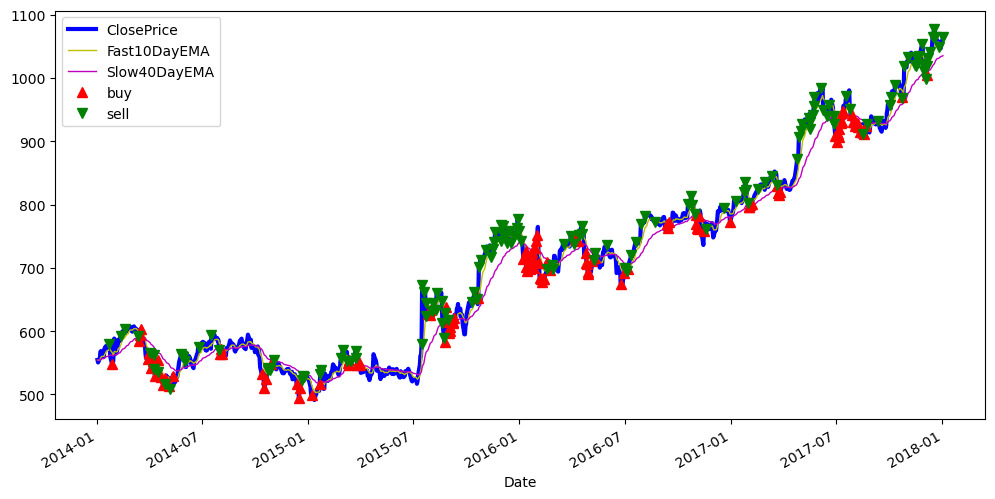

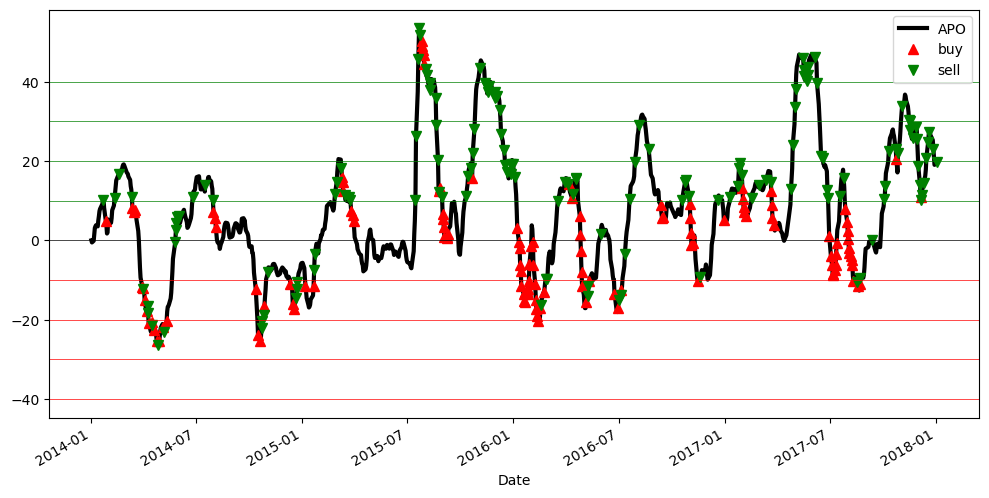

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df['ClosePrice'].plot(color='blue', lw=3., legend=True)
df['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
df['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.ClosePrice[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.ClosePrice[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
df['APO'].plot(color='k', lw=3., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.APO[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.APO[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

11. As we will see in the following code, those trades are the ones executed to close profits. Let's observe the position and PnL evolution over the lifetime of this strategy:

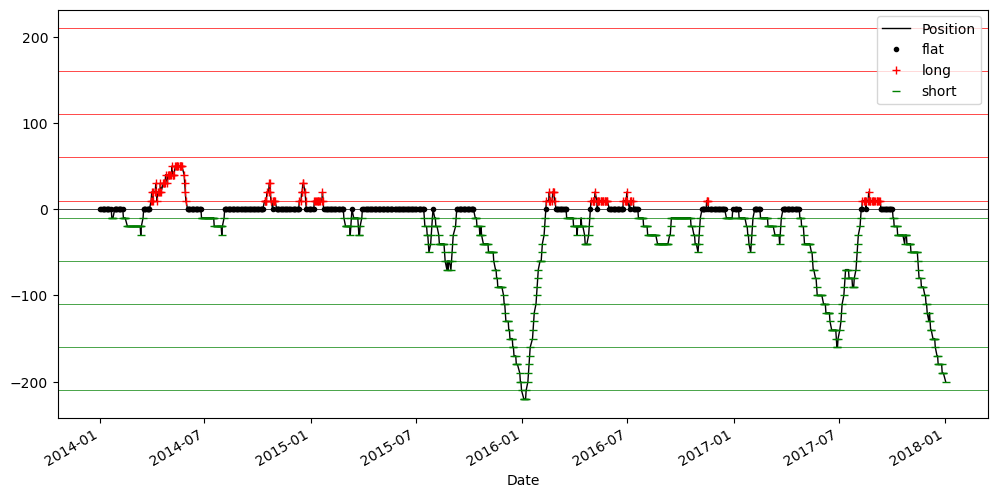

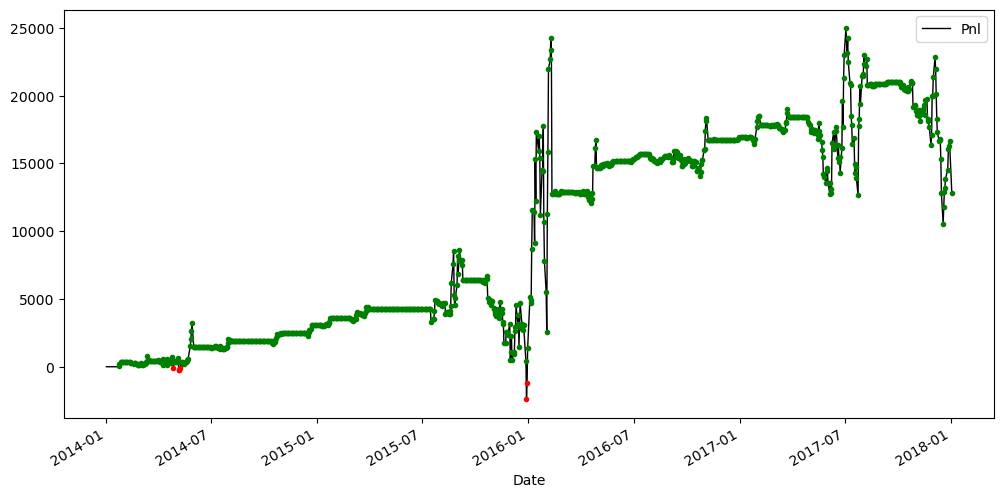

In [11]:
plt.figure(figsize=(12, 6))
df['Position'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Position == 0 ].index, df.Position[ df.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(df.loc[ df.Position > 0 ].index, df.Position[ df.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(df.loc[ df.Position < 0 ].index, df.Position[ df.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
df['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Pnl > 0 ].index, df.Pnl[ df.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(df.loc[ df.Pnl < 0 ].index, df.Pnl[ df.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

df['BasicMeanReversionPnl'] = df['Pnl']
# df.to_csv("basic_mean_reversion.csv", sep=",")

### Mean reversion strategy that dynamically adjusts for changing volatility

* Instead of having static `K_FAST` and `K_SLOW` smoothing factors for the fast and slow EMA, we will instead make them additionally a function of volatility and use `K_FAST * stdev_factor` and `K_SLOW * stdev_factor`, to make them more reactive to newest observations during periods of higher than normal volatility, which makes intuitive sense.
* Instead of using static `APO_VALUE_FOR_BUY_ENTRY` and `APO_VALUE_FOR_SELL_ENTRY` thresholds for entering positions based on the primary trading signal APO, we will also incorporate volatility to have dynamic thresholds `APO_VALUE_FOR_BUY_ENTRY * stdev_factor` and `APO_VALUE_FOR_SELL_ENTRY * stdev_factor`. This makes us less aggressive in entering positions during periods of higher volatility, by increasing the threshold for entry by a factor of volatility, which also makes intuitive sense based on what we discussed in the previous section.
* Finally, we will incorporate volatility in one last threshold and that is by having a dynamic expected profit threshold to lock in profit in a position. In this case, instead of using the static `MIN_PROFIT_TO_CLOSE` threshold, we will use a dynamic `MIN_PROFIT_TO_CLOSE / stdev_factor`. Here, the idea is to be more aggressive in exciting positions during periods of increased volatility, because as we discussed before, during periods of higher than normal volatility, it is riskier to hold on to positions for longer periods of time.

In [12]:
# Variables/constants for EMA Calculation:
NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions,
                #  0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl
            # i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade
                        # made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade
                        # made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = -10 # APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = 10 # APO trading signal value above which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # Minimum price change since last trade before considering trading again,
                                    # this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 10 # Number of shares to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # Minimum Open/Unrealized profit at which to close positions
                                                # and lock profits

In [13]:
import statistics as stats
import math as math

In [14]:
# Constants/variables that are used to compute standard deviation as a volatility measure
SMA_NUM_PERIODS = 20 # look back period
price_history = [] # history of prices

In [15]:
close=df['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > SMA_NUM_PERIODS: # we track at most 'time_period' number of prices
        del (price_history[0])

    sma = stats.mean(price_history)
    variance = 0 # variance is square of standard deviation
    for hist_price in price_history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(price_history))
    stdev_factor = stdev/15
    if stdev_factor == 0:
        stdev_factor = 1

    # This section updates fast and slow EMA and computes APO trading signal
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST*stdev_factor + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW*stdev_factor + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price
    #    and current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position
    #    is profitable enough to lock profit.
    if ((apo > APO_VALUE_FOR_SELL_ENTRY*stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor)
        or # APO above sell entry threshold, we should sell
        (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # long from -ve APO and APO
                                                                                        # has gone positive or position
                                                                                        # is profitable, sell to close
                                                                                        # position
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
        sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price
    #    and current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position
    #    is profitable enough to lock profit.
    elif ((apo < APO_VALUE_FOR_BUY_ENTRY*stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor)
        or # APO below buy entry threshold, we should buy
        (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # short from +ve APO and APO
                                                                                        # has gone negative or position
                                                                                        # is profitable, buy to close
                                                                                        # position
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE # increase position by the size of this trade
        buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update the vwap buy-price
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        # long position and some sell trades have been made against it,
        # close that amount based on how much was sold against this long position
        if sell_sum_qty > 0:
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        # short position and some buy trades have been made against it,
        # close that amount based on how much was bought against this short position
        if buy_sum_qty > 0:
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
    pnls.append(closed_pnl + open_pnl)

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Sell  10  @  573.116821 Position:  -10
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
Sell  10  @  579.677246 Position:  -20
OpenPnL:  -65.60424999999896  ClosedPnL:  0  TotalPnL:  -65.60424999999896
OpenPnL:  -78.75489000000016  ClosedPnL:  0  TotalPnL:  -78.75489000000016
OpenPnL:  -29.738769999999022  ClosedPnL:  0  TotalPnL:  -29.738769999999022
Sell  10  @  559.81665 Position:  -30
OpenPnL:  331.60766999999964  ClosedPnL:  0  TotalPnL:  331.60766999999964
Buy  10  @  548.558838 Position:  -20
OpenPnL:  892.4560399999973  ClosedPnL:  0  Tota

In [16]:
# This section prepares the dataframe from the trading strategy results and visualizes the results
df = df.assign(ClosePrice=pd.Series(close, index=df.index))
df = df.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=df.index))
df = df.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=df.index))
df = df.assign(APO=pd.Series(apo_values, index=df.index))
df = df.assign(Trades=pd.Series(orders, index=df.index))
df = df.assign(Position=pd.Series(positions, index=df.index))
df = df.assign(Pnl=pd.Series(pnls, index=df.index))

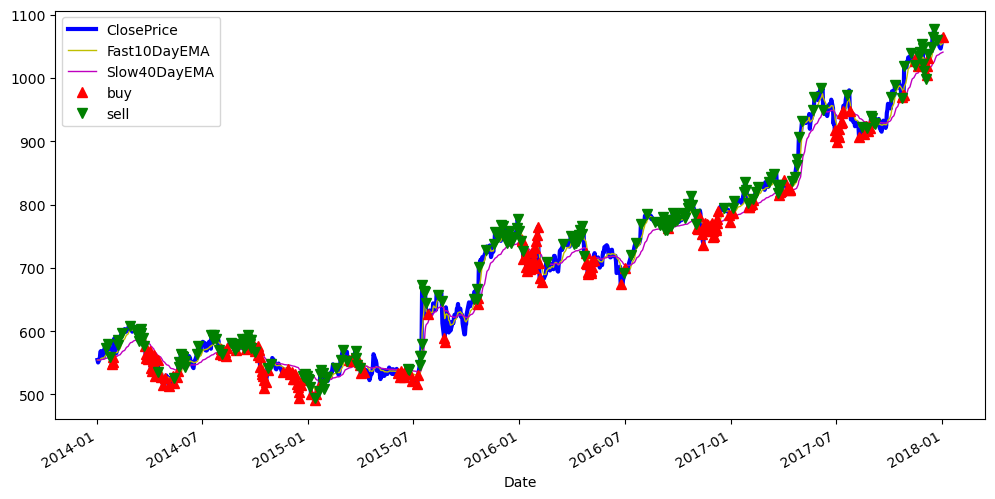

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df['ClosePrice'].plot(color='blue', lw=3., legend=True)
df['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
df['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.ClosePrice[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.ClosePrice[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

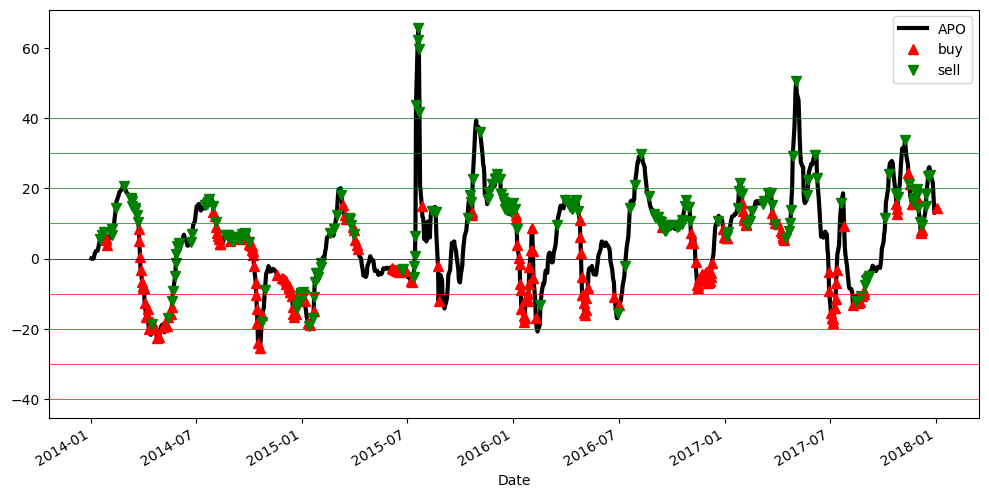

In [18]:
plt.figure(figsize=(12, 6))
df['APO'].plot(color='k', lw=3., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.APO[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.APO[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

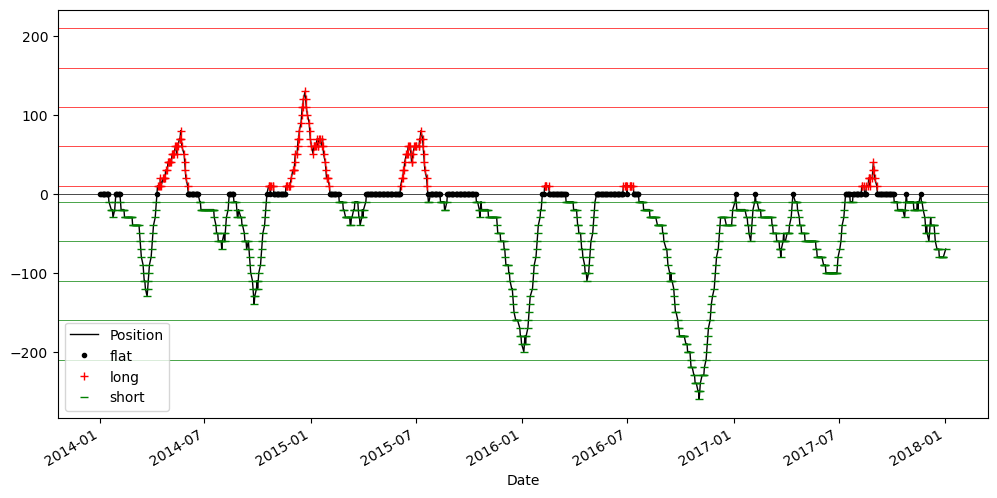

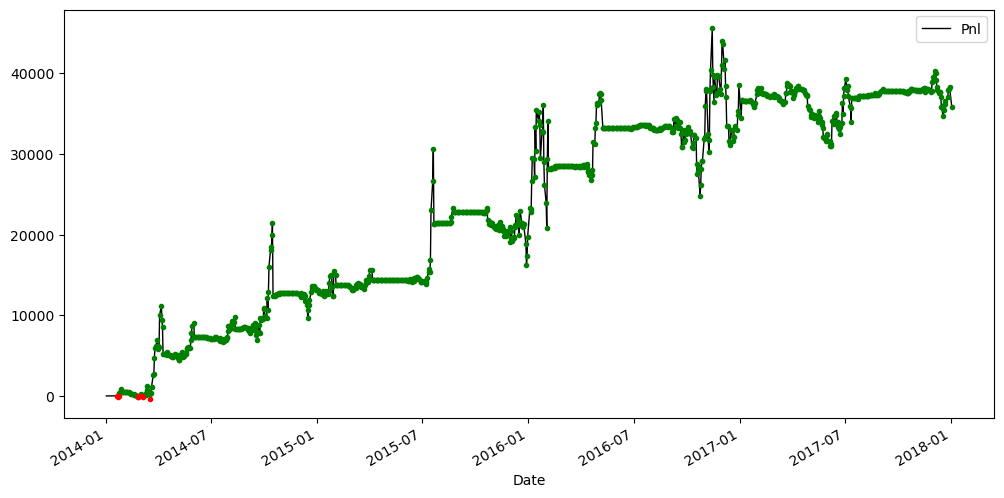

In [19]:
plt.figure(figsize=(12, 6))
df['Position'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Position == 0 ].index, df.Position[ df.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(df.loc[ df.Position > 0 ].index, df.Position[ df.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(df.loc[ df.Position < 0 ].index, df.Position[ df.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
df['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Pnl > 0 ].index, df.Pnl[ df.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(df.loc[ df.Pnl < 0 ].index, df.Pnl[ df.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

df['VolatilityAdjustedMeanReversionPnl'] = df['Pnl']
# data.to_csv("volatility_adjusted_mean_reversion.csv", sep=",")

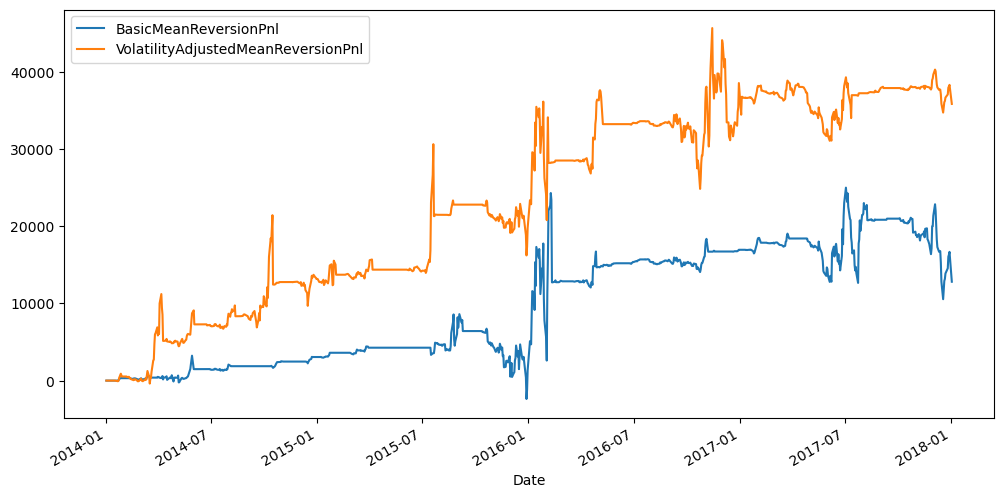

In [20]:
df[['BasicMeanReversionPnl', 'VolatilityAdjustedMeanReversionPnl']].plot(figsize=(12, 6))
plt.show()

### Trend-following strategy using absolute price oscillator trading signal

In [21]:
# Variables/constants for EMA Calculation:
NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

1. First, we define the APO values we will use to enter long/short positions. In this case, the buy entry APO threshold is positive and the sell entry APO threshold is negative:

In [22]:
# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = 10 # APO trading signal value above which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = -10 # APO trading signal value below which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 10 # Number of shares to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # Minimum Open/Unrealized profit at which to close positions and lock profits

2. Next, let's look at the core trading logic that enters and exits positions.

    First, look at the signal and position management code that leads to sell trades:

In [23]:
close=df['Close']
for close_price in close:
    # This section updates fast and slow EMA and computes APO trading signal
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
    if ((apo < APO_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) # APO above sell entry threshold, we should sell
        or
        (position > 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # long from +ve APO and APO has gone negative or position is profitable, sell to close position
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
        sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
    elif ((apo > APO_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) # APO above buy entry threshold, we should buy
        or
        (position < 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # short from -ve APO and APO has gone positive or position is profitable, buy to close position
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE # increase position by the size of this trade
        buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update the vwap buy-price
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0: # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
              open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
    pnls.append(closed_pnl + open_pnl)

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Buy  10  @  580.334778 Position:  10
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
OpenPnL:  -24.50806000000057  ClosedPnL:  0  TotalPnL:  -24.50806000000057
OpenPnL:  -205.18128000000047  ClosedPnL:  0  TotalPnL:  -205.18128000000047
OpenPnL:  -317.7593999999999  ClosedPnL:  0  TotalPnL:  -317.7593999999999
OpenPnL:  -209.26574999999957  ClosedPnL:  0  TotalPnL:  -209.26574999999957
OpenPnL:  -289.4152800000006  ClosedPnL:  0  TotalPnL:  -289.4152800000006
OpenPn

In [24]:
# This section prepares the dataframe from the trading strategy results and visualizes the results
df = df.assign(ClosePrice=pd.Series(close, index=df.index))
df = df.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=df.index))
df = df.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=df.index))
df = df.assign(APO=pd.Series(apo_values, index=df.index))
df = df.assign(Trades=pd.Series(orders, index=df.index))
df = df.assign(Position=pd.Series(positions, index=df.index))
df = df.assign(Pnl=pd.Series(pnls, index=df.index))

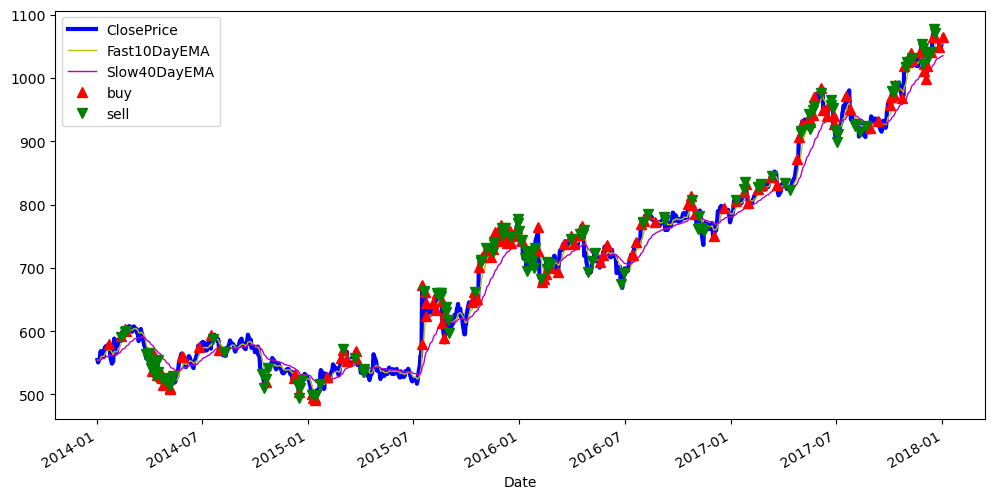

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df['ClosePrice'].plot(color='blue', lw=3., legend=True)
df['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
df['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.ClosePrice[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.ClosePrice[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

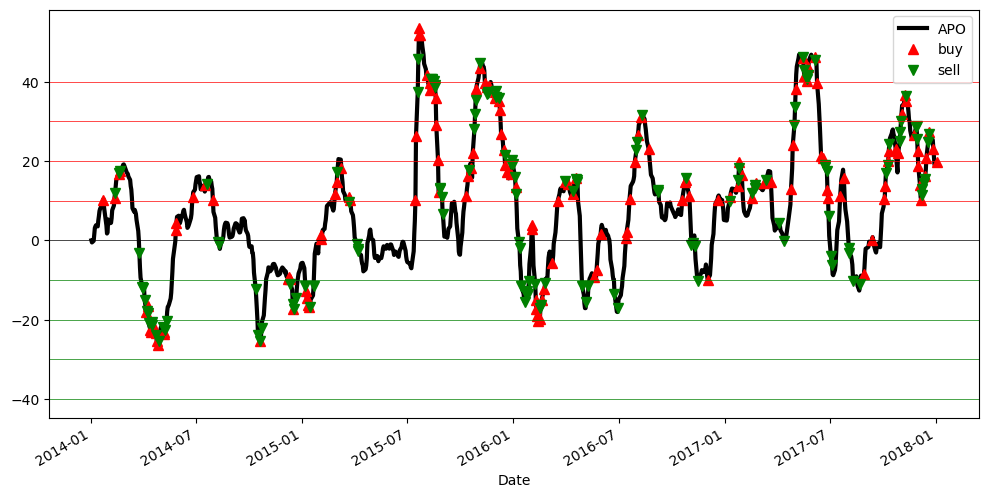

In [26]:
plt.figure(figsize=(12, 6))
df['APO'].plot(color='k', lw=3., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.APO[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.APO[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

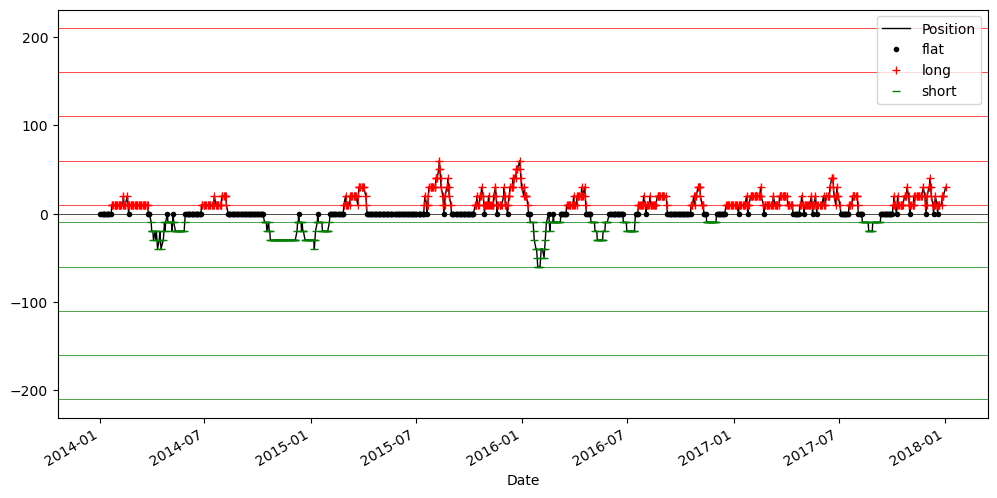

In [27]:
plt.figure(figsize=(12, 6))
df['Position'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Position == 0 ].index, df.Position[ df.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(df.loc[ df.Position > 0 ].index, df.Position[ df.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(df.loc[ df.Position < 0 ].index, df.Position[ df.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

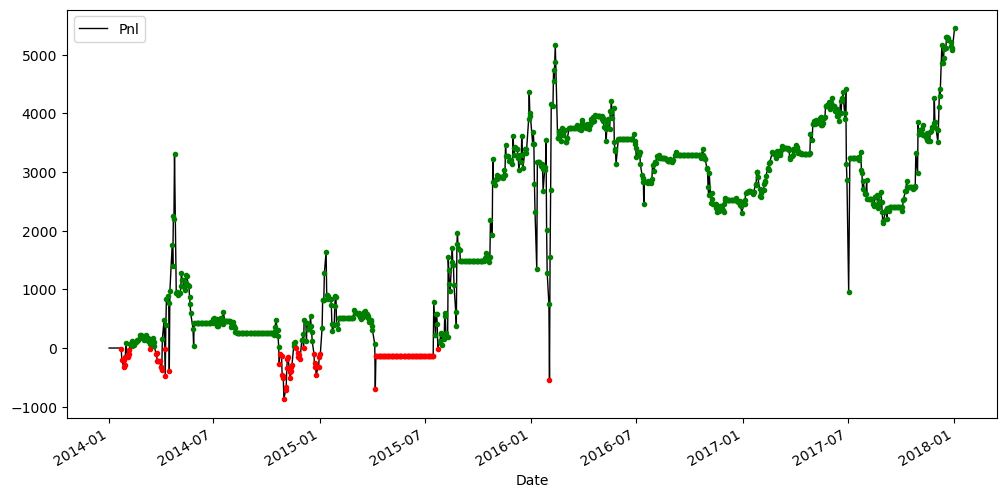

In [28]:
plt.figure(figsize=(12, 6))
df['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Pnl > 0 ].index, df.Pnl[ df.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(df.loc[ df.Pnl < 0 ].index, df.Pnl[ df.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

df['BasicTrendFollowingPnl'] = df['Pnl']
# data.to_csv("basic_trend_following.csv", sep=",")

### Trend-following strategy that dynamically adjusts for changing volatility

In [29]:
# Variables/constants for EMA Calculation:
NUM_PERIODS_FAST = 10 # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

NUM_PERIODS_SLOW = 40 # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

In [30]:
# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = 10 # APO trading signal value above which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = -10 # APO trading signal value below which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
NUM_SHARES_PER_TRADE = 10 # Number of shares to buy/sell on every trade
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # Minimum Open/Unrealized profit at which to close positions and lock profits

In [31]:
import statistics as stats
import math as math

In [32]:
# Constants/variables that are used to compute standard deviation as a volatility measure
SMA_NUM_PERIODS = 20 # look back period
price_history = [] # history of prices

In [33]:
close=df['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > SMA_NUM_PERIODS: # we track at most 'time_period' number of prices
        del (price_history[0])

    sma = stats.mean(price_history)
    variance = 0 # variance is square of standard deviation
    for hist_price in price_history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(price_history))
    stdev_factor = stdev/15
    if stdev_factor == 0:
        stdev_factor = 1

    # This section updates fast and slow EMA and computes APO trading signal
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST*stdev_factor + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW*stdev_factor + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
    if ((apo < APO_VALUE_FOR_SELL_ENTRY/stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) # APO below sell entry threshold, we should sell
        or
        (position > 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # long from +ve APO and APO has gone negative or position is profitable, sell to close position
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
        sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
    elif ((apo > APO_VALUE_FOR_BUY_ENTRY/stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) # APO above buy entry threshold, we should buy
        or
        (position < 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # short from -ve APO and APO has gone positive or position is profitable, buy to close position
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE # increase position by the size of this trade
        buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update the vwap buy-price
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0: # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
    pnls.append(closed_pnl + open_pnl)

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  Clo

In [34]:
# This section prepares the dataframe from the trading strategy results and visualizes the results
df = df.assign(ClosePrice=pd.Series(close, index=df.index))
df = df.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=df.index))
df = df.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=df.index))
df = df.assign(APO=pd.Series(apo_values, index=df.index))
df = df.assign(Trades=pd.Series(orders, index=df.index))
df = df.assign(Position=pd.Series(positions, index=df.index))
df = df.assign(Pnl=pd.Series(pnls, index=df.index))

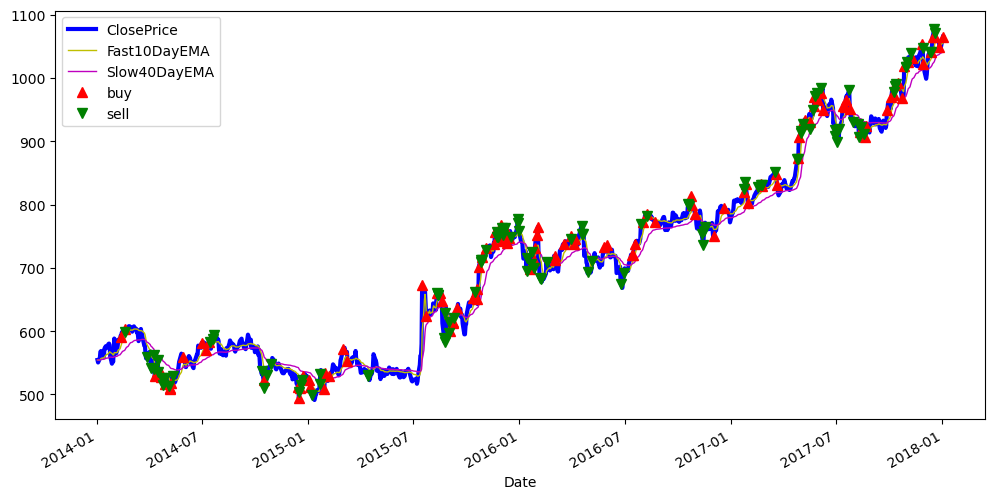

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df['ClosePrice'].plot(color='blue', lw=3., legend=True)
df['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
df['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.ClosePrice[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.ClosePrice[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

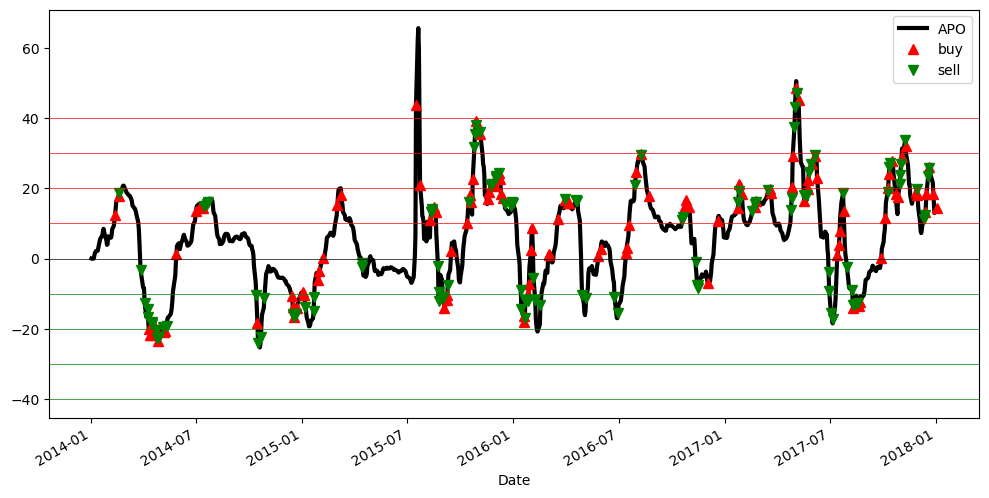

In [36]:
plt.figure(figsize=(12, 6))
df['APO'].plot(color='k', lw=3., legend=True)
plt.plot(df.loc[ df.Trades == 1 ].index, df.APO[df.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(df.loc[ df.Trades == -1 ].index, df.APO[df.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

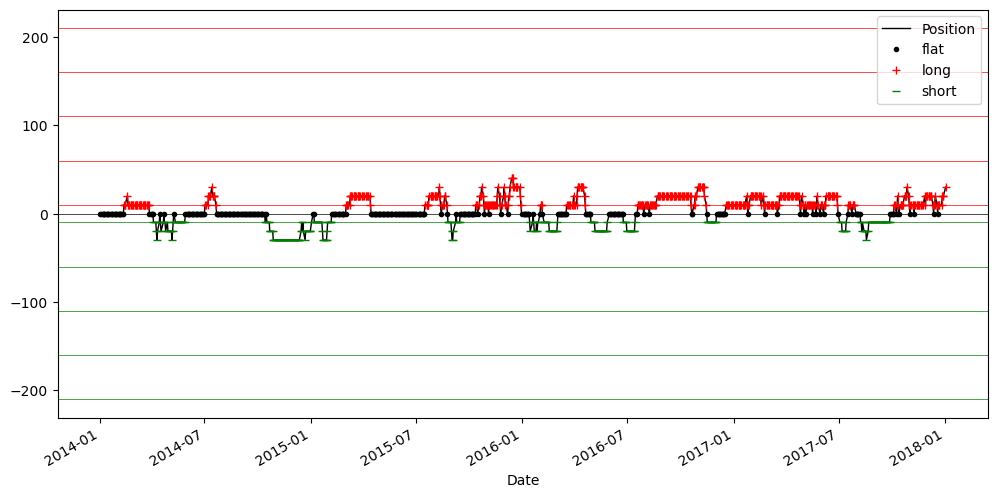

In [37]:
plt.figure(figsize=(12, 6))
df['Position'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Position == 0 ].index, df.Position[ df.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(df.loc[ df.Position > 0 ].index, df.Position[ df.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(df.loc[ df.Position < 0 ].index, df.Position[ df.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

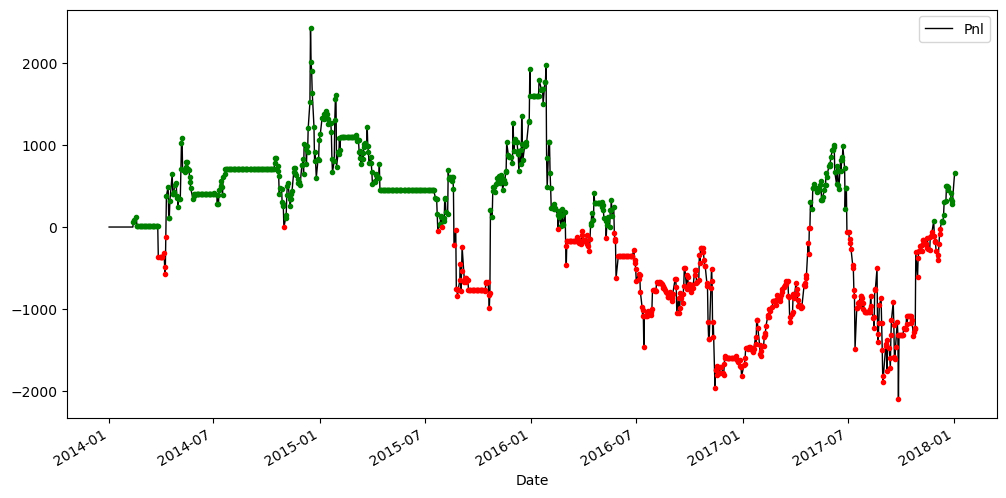

In [38]:
plt.figure(figsize=(12, 6))
df['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(df.loc[ df.Pnl > 0 ].index, df.Pnl[ df.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(df.loc[ df.Pnl < 0 ].index, df.Pnl[ df.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

df['VolatilityAdjustedTrendFollowingPnl'] = df['Pnl']
# data.to_csv("volatility_adjusted_trend_following.csv", sep=",")

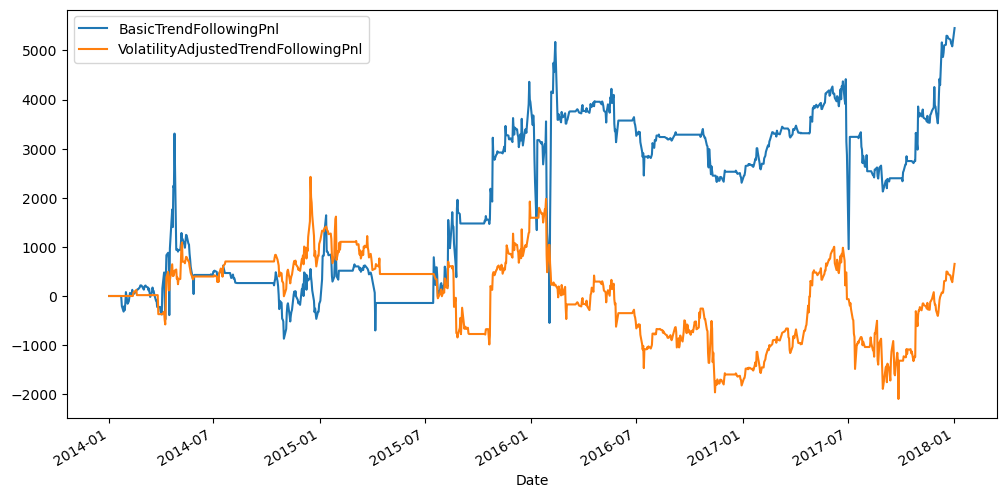

In [39]:
df[['BasicTrendFollowingPnl', 'VolatilityAdjustedTrendFollowingPnl']].plot(figsize=(12, 6))
plt.show()

### Statistical arbitrage trading strategy in Python

#### StatArb data set

Let's first get the data set we will need to implement a StatArb trading strategy. For this section, we will use the following major currencies across the world:
* Austrian Dollar versus American Dollar (AUD/USD)
* British Pound versus American Dollar (GBP/USD)
* Canadian Dollar versus American Dollar (CAD/USD)
* Swiss Franc versus American Dollar (CHF/USD)
* Euro versus American Dollar (EUR/USD)
* Japanese Yen versus American Dollar (JPY/USD)
* New Zealand Kiwi versus American Dollar (NZD/USD)

And for this implementation of the StatArb trading strategy, we will try to trade CAD/USD using its relationship with the other currency pairs:

1. Let's fetch 4 years' worth of data for these currency pairs and set up our data frames:

In [40]:
# Fetch daily data for 4 years, for 7 major currency pairs
TRADING_INSTRUMENT = 'CADUSD=X'
SYMBOLS = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X', 'EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']
START_DATE = '2014-01-01'
END_DATE = '2018-01-01'

In [41]:
# DataSeries for each currency
symbols_data = {}
for symbol in SYMBOLS:
    SRC_DATA_FILENAME = symbol + '_data.pkl'

    try:
        df = pd.read_pickle(SRC_DATA_FILENAME)
    except FileNotFoundError:
        # df = data.DataReader(symbol, 'yahoo', START_DATE, END_DATE)
        df = data.get_data_yahoo(symbol, start=START_DATE, end=END_DATE)
        df.to_pickle(SRC_DATA_FILENAME)

    symbols_data[symbol] = df

2. Let's quickly visualize each currency pair's prices over the period of our data set and see what we observe. We scale the JPY/USD pair by 100.0 purely for visualization scaling purposes:

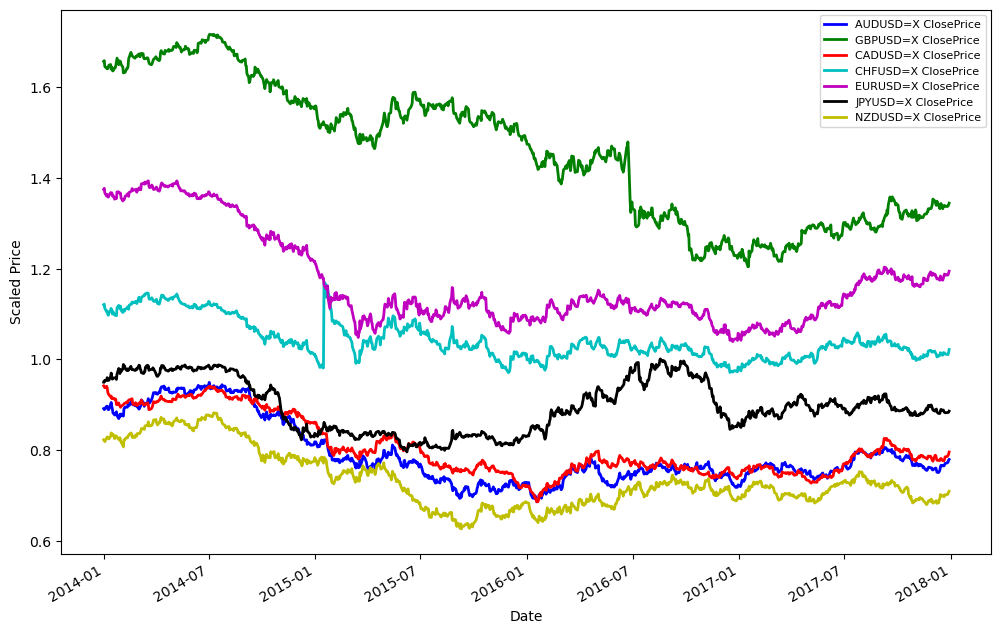

In [42]:
# Visualize prices for currency to inspect relationship between them
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

cycol = cycle('bgrcmky')

price_data = pd.DataFrame()
plt.figure(figsize=(12, 8))
for symbol in SYMBOLS:
    multiplier = 1.0
    if symbol == 'JPYUSD=X':
        multiplier = 100.0

    label = symbol + ' ClosePrice'
    price_data = price_data.assign(label=pd.Series(symbols_data[symbol]['Close'] * multiplier, index=symbols_data[symbol].index))
    ax = price_data['label'].plot(color=next(cycol), lw=2., label=label)

plt.xlabel('Date', fontsize=10)
plt.ylabel('Scaled Price', fontsize=10)
plt.legend(prop={'size': 8})
plt.show()

#### Defining StatArb signal parameters

Now, let's define and quantify some parameters we will need to define moving averages, price deviation from moving averages, history of price deviations, and variables to compute and track correlations:

In [43]:
import statistics as stats

# Constants/variables that are used to compute simple moving average and price deviation from simple moving average
SMA_NUM_PERIODS = 20  # look back period
price_history = {}  # history of prices

PRICE_DEV_NUM_PRICES = 200 # look back period of ClosePrice deviations from SMA
price_deviation_from_sma = {}  # history of ClosePrice deviations from SMA

# We will use this to iterate over all the days of data we have
num_days = len(symbols_data[TRADING_INSTRUMENT].index)
# history of correlations per currency pair
correlation_history = {}
# history of differences between Projected ClosePrice deviation and actual ClosePrice deviation per currency pair
delta_projected_actual_history = {}

# history of differences between final Projected ClosePrice deviation for TRADING_INSTRUMENT and actual
# ClosePrice deviation
final_delta_projected_history = []

#### Defining StatArb trading parameters

Now, before we get into the main strategy loop, let's define some final variables and thresholds we will need to build our StatArb trading strategy:

In [44]:
# Variables for Trading Strategy trade, position & pnl management:
# Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
orders = []
# Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
positions = []
# Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in
# and open_pnl i.e. pnls for open-position marked to market price
pnls = []

# Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_buy_price = 0
# Price at which last sell trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0
# Current position of the trading strategy
position = 0
# Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_price_qty = 0
# Summation of buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0
# Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_price_qty = 0
# Summation of sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0
# Open/Unrealized PnL marked to market
open_pnl = 0
# Closed/Realized PnL so far
closed_pnl = 0

# Constants that define strategy behavior/thresholds

# StatArb trading signal value aboe which to enter buy-orders/long-position
StatArb_VALUE_FOR_BUY_ENTRY = 0.01
# StatArb trading signal value below which to enter sell-orders/short-position
StatArb_VALUE_FOR_SELL_ENTRY = -0.01
# Minimum price change since last trade before considering trading again, this is to prevent over-trading
# at/around same prices
MIN_PRICE_MOVE_FROM_LAST_TRADE = 0.01
# Number of currency to buy/sell on every trade
NUM_SHARES_PER_TRADE = 1000000
# Minimum Open/Unrealized profit at which to close positions and lock profits
MIN_PROFIT_TO_CLOSE = 10

#### Quantifying and computing StatArb trading signals

In [45]:
"""
1. We will see over available prices a day at a time and see what calculations need to be performed,
starting with the computation of SimpleMovingAverages and price deviation from the rolling SMA first:
"""

for i in range(0, num_days):
    close_prices = {}

    # Build ClosePrice series, compute SMA for each symbol and price-deviation from SMA for each symbol
    for symbol in SYMBOLS:
        close_prices[symbol] = symbols_data[symbol]["Close"].iloc[i]
        if not symbol in price_history.keys():
            price_history[symbol] = []
            price_deviation_from_sma[symbol] = []

        price_history[symbol].append(close_prices[symbol])
        if (
            len(price_history[symbol]) > SMA_NUM_PERIODS
        ):  # we track at most SMA_NUM_PERIODS number of prices
            del price_history[symbol][0]

        sma = stats.mean(price_history[symbol])  # Rolling SimpleMovingAverage
        price_deviation_from_sma[symbol].append(
            close_prices[symbol] - sma
        )  # price deviation from mean
        if len(price_deviation_from_sma[symbol]) > PRICE_DEV_NUM_PRICES:
            del price_deviation_from_sma[symbol][0]

    """
    2. Next, we need to compute the relationships between the CAD/USD currency pair price deviations and the
    other currency pair price deviations. We will use covariance and correlation between the series of price
    deviations from SMA that we computed in the previous section. In this same loop, we will also compute the
    CAD/USD price deviation as projected by every other lead currency pair, and see what the difference between
    the projected price deviation and actual price deviation is. We will need these individual deltas between
    projected price deviation and actual price deviation to get a final delta value that we will use for trading.
    
    First, let's look at the code block that populates the 'correlation_history' and the
    'delta_projected_actual_history' dictionaries:
    """
            
    # Now compute covariance and correlation between TRADING_INSTRUMENT and every other lead symbol
    # also compute projected price deviation and find delta between projected and actual price deviations.
    projected_dev_from_sma_using = {}
    for symbol in SYMBOLS:
        if (
            symbol == TRADING_INSTRUMENT
        ):  # no need to find relationship between trading instrument and itself
            continue

        correlation_label = TRADING_INSTRUMENT + "<-" + symbol
        if (
            correlation_label not in correlation_history.keys()
        ):  # first entry for this pair in the history dictionary
            correlation_history[correlation_label] = []
            delta_projected_actual_history[correlation_label] = []

        if (
            len(price_deviation_from_sma[symbol]) < 2
        ):  # need atleast two observations to compute covariance/correlation
            correlation_history[correlation_label].append(0)
            delta_projected_actual_history[correlation_label].append(0)
            continue

        """
        Now, let's look at the code block to compute correlation and covariance between the currency pairs:
        """
            
        corr = np.corrcoef(
            price_deviation_from_sma[TRADING_INSTRUMENT],
            price_deviation_from_sma[symbol],
        )
        cov = np.cov(
            price_deviation_from_sma[TRADING_INSTRUMENT],
            price_deviation_from_sma[symbol],
        )
        corr_trading_instrument_lead_instrument = corr[
            0, 1
        ]  # get the correlation between the 2 series
        cov_trading_instrument_lead_instrument = (
            cov[0, 0] / cov[0, 1]
        )  # get the covariance between the 2 series

        correlation_history[correlation_label].append(
            corr_trading_instrument_lead_instrument
        )
        
        """
        Finally, let's look at the code block that computes the projected price movement, uses that to find
        the difference between the projected movement and actual movement, and saves it in our 
        'delta_projected_actual_history' list per currency pair:
        """

        # projected-price-deviation-in-TRADING_INSTRUMENT is covariance * price-deviation-in-lead-symbol
        projected_dev_from_sma_using[symbol] = (
            price_deviation_from_sma[symbol][-1]
            * cov_trading_instrument_lead_instrument
        )

        # delta +ve => signal says TRADING_INSTRUMENT price should have moved up more than what it did
        # delta -ve => signal says TRADING_INSTRUMENT price should have moved down more than what it did.
        delta_projected_actual = (
            projected_dev_from_sma_using[symbol]
            - price_deviation_from_sma[TRADING_INSTRUMENT][-1]
        )
        delta_projected_actual_history[correlation_label].append(delta_projected_actual)

    """
    3. Let's combine these individual deltas between projected and actual price deviation in CAD/USD to get one
    final StatArb signal value for CAD/USD that is a combination of projections from all the other currency pairs.
    To combine these different projections, we will use the magnitude of the correlation between CAD/USD and the
    other currency pairs to weigh the delta between projected and actual price deviations in CAD/USD as predicted
    by the other pairs. Finally, we will normalize the final delta value by the sum of each individual weight
    (magnitude of correlation) and that is what we will use as our final signal to build our trading strategy around:
    """
        
    # weigh predictions from each pair, weight is the correlation between those pairs
    sum_weights = 0  # sum of weights is sum of correlations for each symbol with TRADING_INSTRUMENT
    for symbol in SYMBOLS:
        if (
            symbol == TRADING_INSTRUMENT
        ):  # no need to find relationship between trading instrument and itself
            continue

        correlation_label = TRADING_INSTRUMENT + "<-" + symbol
        sum_weights += abs(correlation_history[correlation_label][-1])

    final_delta_projected = 0  # will hold final prediction of price deviation in TRADING_INSTRUMENT, weighing projections from all other symbols.
    close_price = close_prices[TRADING_INSTRUMENT]
    for symbol in SYMBOLS:
        if (
            symbol == TRADING_INSTRUMENT
        ):  # no need to find relationship between trading instrument and itself
            continue

        correlation_label = TRADING_INSTRUMENT + "<-" + symbol

        # weight projection from a symbol by correlation
        final_delta_projected += (
            abs(correlation_history[correlation_label][-1])
            * delta_projected_actual_history[correlation_label][-1]
        )

    # normalize by diving by sum of weights for all pairs
    if sum_weights != 0:
        final_delta_projected /= sum_weights
    else:
        final_delta_projected = 0

    final_delta_projected_history.append(final_delta_projected)

    # This section checks trading signal against trading parameters/thresholds and positions, to trade.
    #
    # We will perform a sell trade at close_prices if the following conditions are met:
    # 1. The StatArb trading signal value is below Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are long( +ve position ) and current position is profitable enough to lock profit.
    if (
        final_delta_projected < StatArb_VALUE_FOR_SELL_ENTRY
        and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE
    ) or (  # StatArb above sell entry threshold, we should sell
        position > 0 and (open_pnl > MIN_PROFIT_TO_CLOSE)
    ):  # long from -ve StatArb and StatArb has gone positive or position is profitable, sell to close position
        orders.append(-1)  # mark the sell trade
        last_sell_price = close_price
        position -= NUM_SHARES_PER_TRADE  # reduce position by the size of this trade
        sell_sum_price_qty += (
            close_price * NUM_SHARES_PER_TRADE
        )  # update vwap sell-price
        sell_sum_qty += NUM_SHARES_PER_TRADE
        print("Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
        print(
            "OpenPnL: ",
            open_pnl,
            " ClosedPnL: ",
            closed_pnl,
            " TotalPnL: ",
            (open_pnl + closed_pnl),
        )

    # We will perform a buy trade at close_prices if the following conditions are met:
    # 1. The StatArb trading signal value is above Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are short( -ve position ) and current position is profitable enough to lock profit.
    elif (
        final_delta_projected > StatArb_VALUE_FOR_BUY_ENTRY
        and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE
    ) or (  # StatArb below buy entry threshold, we should buy
        position < 0 and (open_pnl > MIN_PROFIT_TO_CLOSE)
    ):  # short from +ve StatArb and StatArb has gone negative or position is profitable, buy to close position
        orders.append(+1)  # mark the buy trade
        last_buy_price = close_price
        position += NUM_SHARES_PER_TRADE  # increase position by the size of this trade
        buy_sum_price_qty += (
            close_price * NUM_SHARES_PER_TRADE
        )  # update the vwap buy-price
        buy_sum_qty += NUM_SHARES_PER_TRADE
        print("Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
        print(
            "OpenPnL: ",
            open_pnl,
            " ClosedPnL: ",
            closed_pnl,
            " TotalPnL: ",
            (open_pnl + closed_pnl),
        )
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if (
            sell_sum_qty > 0
        ):  # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (
                sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty
            )
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (
            close_price - buy_sum_price_qty / buy_sum_qty
        )
    elif position < 0:
        if (
            buy_sum_qty > 0
        ):  # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (
                sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty
            )
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (
            sell_sum_price_qty / sell_sum_qty - close_price
        )
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += sell_sum_price_qty - buy_sum_price_qty
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    pnls.append(closed_pnl + open_pnl)


Sell  1000000  @  0.9170862436294556 Position:  -1000000
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Buy  1000000  @  0.9133921265602112 Position:  0
OpenPnL:  3610.670566558838  ClosedPnL:  0  TotalPnL:  3610.670566558838
Buy  1000000  @  0.9119926691055298 Position:  1000000
OpenPnL:  0  ClosedPnL:  3694.1170692443848  TotalPnL:  3694.1170692443848
Sell  1000000  @  0.9117432832717896 Position:  0
OpenPnL:  1049.2205619812012  ClosedPnL:  3694.1170692443848  TotalPnL:  4743.337631225586
Sell  1000000  @  0.9007385969161987 Position:  -1000000
OpenPnL:  0  ClosedPnL:  3444.7312355041504  TotalPnL:  3444.7312355041504
Buy  1000000  @  0.90399569272995 Position:  0
OpenPnL:  883.4600448608398  ClosedPnL:  3444.7312355041504  TotalPnL:  4328.19128036499
Buy  1000000  @  0.9127418398857117 Position:  1000000
OpenPnL:  0  ClosedPnL:  187.6354217529297  TotalPnL:  187.6354217529297
Sell  1000000  @  0.9033423662185669 Position:  0
OpenPnL:  383.4366798400879  ClosedPnL:  187.6354217529297  Tot

Buy  1000000  @  0.7538124322891235 Position:  0
OpenPnL:  5986.75012588501  ClosedPnL:  88365.07797241211  TotalPnL:  94351.82809829712
Sell  1000000  @  0.7540454864501953 Position:  -1000000
OpenPnL:  0  ClosedPnL:  92645.28751373291  TotalPnL:  92645.28751373291
Buy  1000000  @  0.750750720500946 Position:  0
OpenPnL:  1146.7933654785156  ClosedPnL:  92645.28751373291  TotalPnL:  93792.08087921143
Sell  1000000  @  0.7508860230445862 Position:  -1000000
OpenPnL:  0  ClosedPnL:  95940.05346298218  TotalPnL:  95940.05346298218
Buy  1000000  @  0.7484861612319946 Position:  0
OpenPnL:  2170.085906982422  ClosedPnL:  95940.05346298218  TotalPnL:  98110.1393699646
Buy  1000000  @  0.7492376565933228 Position:  1000000
OpenPnL:  0  ClosedPnL:  98339.91527557373  TotalPnL:  98339.91527557373
Buy  1000000  @  0.736409604549408 Position:  2000000
OpenPnL:  -8957.505226135254  ClosedPnL:  98339.91527557373  TotalPnL:  89382.41004943848
Buy  1000000  @  0.7251631617546082 Position:  3000000
O

Buy  1000000  @  0.801796019077301 Position:  0
OpenPnL:  5309.700965881348  ClosedPnL:  77715.15846252441  TotalPnL:  83024.85942840576
Sell  1000000  @  0.8078523278236389 Position:  -1000000
OpenPnL:  0  ClosedPnL:  73157.48929977417  TotalPnL:  73157.48929977417
Buy  1000000  @  0.808531641960144 Position:  0
OpenPnL:  2238.8100624084473  ClosedPnL:  73157.48929977417  TotalPnL:  75396.29936218262
Sell  1000000  @  0.8217467069625854 Position:  -1000000
OpenPnL:  0  ClosedPnL:  72478.17516326904  TotalPnL:  72478.17516326904
Buy  1000000  @  0.8143255710601807 Position:  0
OpenPnL:  1940.1907920837402  ClosedPnL:  72478.17516326904  TotalPnL:  74418.36595535278
Sell  1000000  @  0.8006277084350586 Position:  -1000000
OpenPnL:  0  ClosedPnL:  79899.31106567383  TotalPnL:  79899.31106567383
Buy  1000000  @  0.7976834774017334 Position:  0
OpenPnL:  5006.849765777588  ClosedPnL:  79899.31106567383  TotalPnL:  84906.16083145142
Sell  1000000  @  0.7966350317001343 Position:  -1000000
O

#### StatArb signal and strategy performance analysis

Now, let's analyze the StatArb signal using the following steps:

1. Let's visualize a few more details about the signals in this trading strategy, starting with the correlations between CAD/USD and the other currency pairs as it evolves over time:

This plot shows the correlation between CADUSD and other currency pairs as it evolves over the course of this trading strategy. Correlations close to -1 or +1 signify strongly correlated pairs, and correlations that hold steady are the stable correlated pairs. Currency pairs where correlations swing around between negative and positive values indicate extremely uncorrelated or unstable currency pairs, which are unlikely to yield good predictions in the long run. However, we do not know how the correlation would evolve ahead of time, so we have no choice but to use all currency pairs available to us in our StatArb trading strategy:

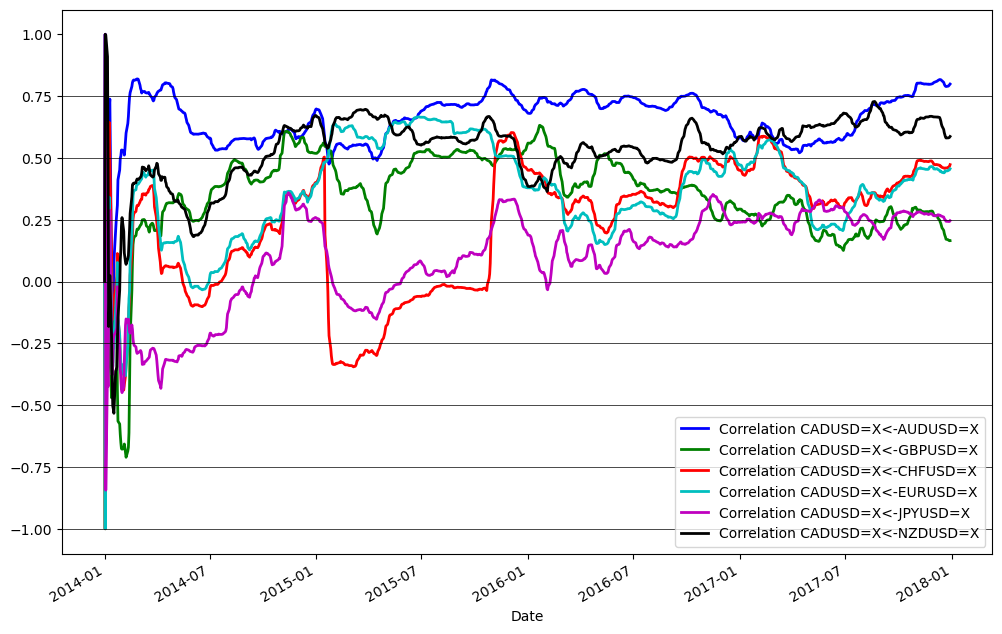

In [46]:
# Plot correlations between TRADING_INSTRUMENT and other currency pairs
plt.figure(figsize=(12, 8))
correlation_data = pd.DataFrame()
for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:
        continue

    correlation_label = TRADING_INSTRUMENT + "<-" + symbol
    correlation_data = correlation_data.assign(
        label=pd.Series(
            correlation_history[correlation_label], index=symbols_data[symbol].index
        )
    )
    ax = correlation_data["label"].plot(
        color=next(cycol), lw=2.0, label="Correlation " + correlation_label
    )

for i in np.arange(-1, 1, 0.25):
    plt.axhline(y=i, lw=0.5, color="k")
plt.legend()
plt.show()

As we suspected, the currency pairs that are most strongly correlated to CAD/USD price deviations are AUD/USD and NZD/USD. JPY/USD is the least correlated to CAD/USD price deviations.

2. Now, let's inspect the delta between projected and actual price deviations in CAD/USD as projected by each individual currency pair individually:

This is what the StatArb signal values would look like if we used any of the currency pairs alone to project CAD/USD price deviations:

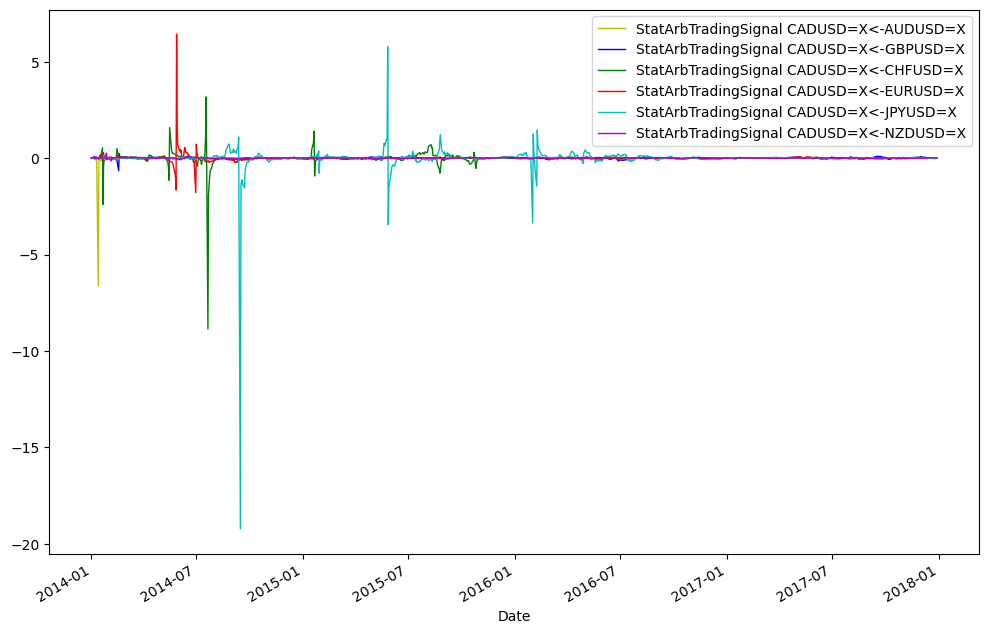

In [47]:
# Plot StatArb signal provided by each currency pair
plt.figure(figsize=(12, 8))
delta_projected_actual_data = pd.DataFrame()
for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:
        continue

    projection_label = TRADING_INSTRUMENT + "<-" + symbol
    delta_projected_actual_data = delta_projected_actual_data.assign(
        StatArbTradingSignal=pd.Series(
            delta_projected_actual_history[projection_label],
            index=symbols_data[TRADING_INSTRUMENT].index,
        )
    )
    ax = delta_projected_actual_data["StatArbTradingSignal"].plot(
        color=next(cycol), lw=1.0, label="StatArbTradingSignal " + projection_label
    )
plt.legend()
plt.show()

3. Now, let's set up our data frames to plot the close price, trades, positions, and PnLs we will observe: